# Malaria Project

## Introduction 
### Members
#### Student 1
Name: Sebastian Schwarz
<br>Group : intermediate
#### Student 2
Name : Youssef Hantous
<br>Group : intermediate


### Data name :
**A geo-coded inventory of anophelines in the Afrotropical Region south of the Sahara: 1898-2016**

### Data URL : 
- Kaggle: https://www.kaggle.com/jboysen/malaria-mosquito 
- Dataverse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/NQ6CUN
<br>The paper describing how this dataset was compiled can be found here: https://wellcomeopenresearch.org/articles/2-57/v1 

##### Project Description
The aim of this project is to study the distribution and evolution of anophenile vectors of Malaria in Africa. 
The dataset is a compilation of all available mosquito studies from 1898 to 2016. It was compiled in *Kyalo D, Amratia P, Mundia CW et al. A geo-coded inventory of anophelines in the Afrotropical Region south of the Sahara: 1898-2016*, published in 2017 with the help of the KEMRI-Wellcome Trust, in collaboration with many major research agencies on Malaria. 

This data should help better understand how malaria developped in the past century and what species are primarily associated with its expansion. 

We want to present this data in a clear fashion, showing trends in the evolution and the spread of anopheniles in Africa, and try to predict the future repartition of main malaria transmitting species. 

##### Github Repository
- https://github.com/SebastianS09/Malaria (peut être pas) 


## Code
#### Data Import auditing and cleaning

In [ ]:
import numpy as np 
import pandas as pd 

data_raw = pd.read_csv("https://raw.githubusercontent.com/SebastianS09/Malaria/master/Data/Malaria.csv")

print("The dataset has ",data_raw.shape[0],"rows and ",data_raw.shape[1],"columns")

data_raw.head(10)


One observation of the data set is associated with one location, time and a source study. 
The location information is displayed as follows: 
- Country and Village name
- GAUL administrative regions (https://en.wikipedia.org/wiki/Global_Administrative_Unit_Layers) which are a unified spatial admnistrative unit system
- Geospatial coordinates and source

Each survey has a start and an end date. We will audit this in the next cell

There is supplementary information on the survey namely:
- Adults/Larvae: whether the survey was conducts on adults or larvae (live in water), sometimes unknown
- Sampling methods: how the speciemens where caught 
- Identification methods: how they were attributed to one species
- Other names and other species: if the species found also have other names and if they were other species present than the main 36 quoted
Details of the abreviations can be found here: https://github.com/SebastianS09/Malaria/blob/master/Data/Africa%20Vectors%20database_1898-2016_key.pdf

We will explore this supplementary information later

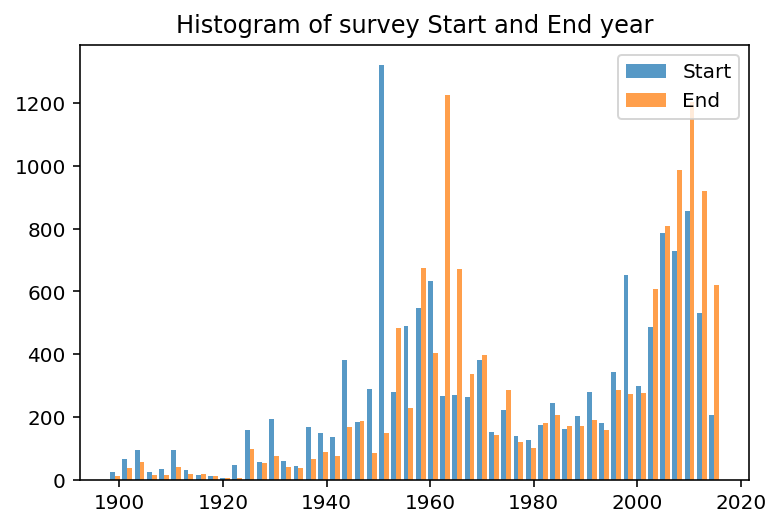

In [509]:
import matplotlib.pyplot as plt
#increasing size of graphs
plt.rcParams['figure.dpi'] = 72*2

dates = np.vstack([data_raw["YeStart"],data_raw["YeEnd"]]).T
plt.hist(dates,bins=50, alpha=0.75, label=['Start', 'End'])
plt.legend(loc='upper right')
plt.title("Histogram of survey Start and End year")
plt.show()

As we can see, most of the surveys have been executed around the 60s and in the late 2000s. 

However, the start year and the end year do not always coincide, meaning that the surveys may have been run on periods extending one year. Let us look into this with more detail. 

In [ ]:
length = dates[:,1]-dates[:,0]
plt.hist(length, bins=50, facecolor="blue", alpha=0.75)
plt.title("Histogram of Survey length")
plt.show()

Most of the surveys have lasted for less than five years which seems reasonable. 
The fact that there is a non zero number of surveys lasting more than 20 years however is surprising. 
Let us look at this data and query the unique study titles associated to these long period surveys

In [ ]:
long_survey = data_raw[["YeStart","YeEnd","Source_Title"]].query("YeEnd-YeStart>20")
pd.DataFrame(long_survey)

In [ ]:
pd.DataFrame(long_survey["Source_Title"].value_counts().sort_values(ascending = False))

Looking at this summary data, it seems that republication dates have sometimes be taken into account as end dates (see Hamon J studies for example). 

**Moving forward, we will therefore use the start date as the reference date.** We would suggest auditing these long period cases for the sake of the datasets integrity, even if it does not affect us very much here.

Let us move forward and clean the data to only keep the rows we need in our anlaysis. 

##### Removing unecessary geographical precision and study information

In [ ]:
#harmonizing column names to avoid errors
data_raw.columns = [i.replace(' ', '_') for i in data_raw.columns]
data_raw.columns = [i.replace('.', '_') for i in data_raw.columns]
data_raw.columns = [i.replace('/', '_') for i in data_raw.columns]
col_rm = ['GAUL_Admin2','Full_Name','LatLong_Source','Source_Title']
data_rm = data_raw.drop(col_rm, axis=1)

##### Cleaning Adults/Larvae field for Case

We notice that we have an occurence of Adults/larvae with a minuscule which we want to clean

In [ ]:
data_raw["Adults_Larvae"] = data_raw["Adults_Larvae"].replace("Adults, larvae","Adults, Larvae")

##### Replacing Y and NaN with 0 and 1 for ease of understanding (col 7 to 33)
As we can see, the presence of an anophenile is encoded in columns holding the species' names, with "Yes" if it is present and "NaN" otherwise. 
We will replace these values to 0 and 1 to be able to perform mathematical operations on the columns

In [ ]:
data_clean = data_rm.copy()

ano = list(data_clean)[6:32]
data_clean[ano] = data_clean[ano].replace(['Y'],1)
data_clean[ano] = data_clean[ano].fillna(0)

data_clean.head(10)

In [ ]:
data_clean.describe(include="all")

##### Editing Other Species
We see that we have other species not mentionned in the column names in the last column. Let us check if they are relevant (in terms of frequency vs. species with dedicated columns):

In [ ]:
#splitting the last column as the additional are comma separated
other_f = data_clean['Other_Anopheline_species'].str.split(', ', expand=True)
other_f.fillna(0,inplace=True)

#counting the occurence in each new column
a = other_f[0].value_counts().to_frame()
for i in list(other_f.drop(0,axis=1)):
    a = a.join(other_f[i].value_counts().to_frame())
a.fillna(0,inplace=True)

#summing the columns up to have a definite count
pd.DataFrame(a.sum(axis=1).sort_values(ascending = False)[1:,])

In [ ]:
pd.DataFrame(data_clean[ano].sum(axis=0).sort_values(ascending = False))

As we can see, there are quite high occuring species in "Others". they would rank above An Mouscheti in the primary vector classification. 

However, and as stated in the abstract, the classification has not be done exclusively on occurence. According to the authors of the dataset, *"The definition of secondary vectors is complex and often site/time specific"* We refer to the paper for further information but the main point is that secondary vectors do not transmit paludism to humans, or in very rare cases. 

For the sake of the exercise and reflecting information of this databse of anopheniles: http://bioinfo-web.mpl.ird.fr/identiciels/anopheles/html/taxa/pretoriensis_A_.html, we will add  An Pretoriensis to the primary vectors as they have been transmitting fever generating arboviruses in Nigeria

In [ ]:
An_pretoriensis = data_clean["Other_Anopheline_species"].str.contains("An pretoriensis").fillna(0)*1
data_clean.insert(32,"An_pretoriensis",An_pretoriensis)


#### MetaData analysis
Let us explore the metadata associated to the records which is:
- Adults/Larvae
- Sampling_Methods
- Species_Identification

We will start with some quick summarizing and plotting

##### Species type survey Attributes in time and Space

In [ ]:
AL = data_raw[["YeStart","Adults_Larvae"]]
AL_pivot = AL.reset_index().pivot_table(index = "YeStart", columns = "Adults_Larvae",aggfunc=lambda x: len(x.unique())).fillna(0)
AL_pivot.columns = AL_pivot.columns.droplevel()

x = AL_pivot.index.values
y = np.vstack(AL_pivot[i] for i in AL_pivot.columns)
y_norm = (y/y.sum(axis=0))
lbs = list(AL_pivot)

test = pd.DataFrame(y_norm.T,columns=lbs)
test.index = x
test.plot.bar(stacked = True)

#ax = plt.subplot(111)
#ax.bar(x-0.2, y[0],width=0.1,color='b',align='center', label = AL_pivot.columns[0])
#ax.bar(x-0.1, y[1],width=0.1,color='g',align='center',label = AL_pivot.columns[1])
#ax.bar(x+0.1, y[2],width=0.1,color='r',align='center',label = AL_pivot.columns[2])
#ax.bar(x+0.2, y[3],width=0.1,color='y',align='center',label = AL_pivot.columns[3])

ax = plt.gca() 
ax.set_xticks(range(2,120,10))
ax.set_xticklabels(range(1900,2020,10))

plt.legend(loc='upper left',ncol=4, mode="expand")
plt.title("Bar Chart of survey type")
plt.ylim(ymax = 1.2, ymin = 0)
plt.show()

It appears that over time, surveys focused in particular on Adults but also Larvae are prefered over mixed surveys. This makes sense as it must be easier to distinguish species and to make more accurate surveys. 
Also, Unknown survey tend to diminish over time, due to better reporting

Let us check if there is a geographical influence:

In [ ]:
#function to calculate breaks in a sorted daataframe
def get_lim(df,col):
    val=df[col].unique()
    temp = []
    temp_s = [0]
    out = []
    for i in range(0,len(val)):
        temp.append(len(df[df[col]==val[i]]))
    for i in range(0,len(val)):
        temp_s.append(sum(temp[0:i+1]))
    for i in range(0,len(val)):
        out.append((temp_s[i],temp_s[i+1]))
    return(out)    

#function to generate colormaps

import colorsys

def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, 0.9, 0.9) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

In [465]:
import plotly as py
from plotly import tools

py.offline.init_notebook_mode(connected=True)

AL_G = data_raw[data_raw["YeStart"]>1980][["Adults_Larvae","Lat","Long"]]
AL_G = AL_G.sort_values(["Adults_Larvae"])

limits = get_lim(AL_G,"Adults_Larvae")
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)"]
data = []
names=lbs

for i in range(len(limits)):
    lim = limits[i]
    df_sub = AL_G[lim[0]:lim[1]]
    data.append(dict(
        type = 'scattergeo',
        locationmode = 'africa',
        lon = df_sub['Long'],
        lat = df_sub['Lat'],
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name=names[i])
               )

layout = dict(
        title = 'Historical evolution of Malaria',
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=data, layout=layout)

py.offline.iplot(fig)

From a Geographical perspective, there appears to be no particular preference of survey type since the sixties. 
Plotting before the sixties show that surveys conducted in central Africa tend to have more Unknowns. 


##### Sampling Methods

Let us compute the top 10 sampling methods

Here the abreviations as a reminder:

<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Abreviation</th><th>Description</th></tr></thead><tbody>
 <tr><td>ABC</td><td>Animal Bait Catches</td></tr>
 <tr><td>Bednet traps</td><td>Bed net traps</td></tr>
 <tr><td>CDC Light traps</td><td>CDC light traps</td></tr>
 <tr><td>HBC/NBC</td><td>Human/Night Bait Catches (may be witnin a double sided net)</td></tr>
 <tr><td>HLC</td><td>Human Landing Catches </td></tr>
 <tr><td>NBC</td><td>Night Bait Catches</td></tr>
 <tr><td>IR</td><td>Indoor resting (Often written as room searches, aspirators or hand catches indoors)</td></tr>
 <tr><td>OS</td><td>Outdoor sampling</td></tr>
 <tr><td>LC</td><td>Larval Collections</td></tr>
 <tr><td>Exit traps</td><td>Exit traps</td></tr>
 <tr><td>PSC </td><td>Pyrethrum Spray Catches</td></tr>
 <tr><td>ITT </td><td>Ifakara Tent Traps</td></tr>
</tbody></table>

In [ ]:
top_methods = pd.DataFrame(pd.Series(' '.join(data_clean['Sampling_Methods']+",").split(", ")).value_counts()[:10], columns = ["Count"])

#let us check the evolution of the top 3 cathing methods over time 

M0 = data_clean[data_clean['Sampling_Methods'].str.match(top_methods.index[0])]["YeStart"]
M1 = data_clean[data_clean['Sampling_Methods'].str.match(top_methods.index[1])]["YeStart"]
M2 = data_clean[data_clean['Sampling_Methods'].str.match(top_methods.index[2])]["YeStart"]
MU = data_clean[data_clean['Sampling_Methods'].str.match("Unknown")]["YeStart"]


M0v = M0.value_counts()
M1v = M1.value_counts()
M2v = M2.value_counts()
MUv = MU.value_counts()

conc = pd.concat([M0v,M1v,M2v,MUv],axis=1)
conc.columns=[top_methods.index[[0,1,2,4]]]
conc.plot.bar(stacked=True)

ax = plt.gca() 
ax.set_xticks(range(2,120,10))
ax.set_xticklabels(range(1900,2020,10))
plt.title("Bar Chart of collection method")
plt.ylim(ymax = 300, ymin = 0)
plt.show()

We observe a diminution of "Unknown" methods over time, again due to better accountability

Larval collection is on the rise in the 2000s, after having been used in the 50s and the 60s
In-house capture seems to be the more and more used (makes sense as the propagation of malaria is mainly due to anopheniles that attack humans inside their houses)

However, there is a prevalence of mixed methods: 

In [ ]:
multiple_occ = pd.DataFrame([data_clean["Sampling_Methods"],data_clean["Sampling_Methods"].str.count(", ")+1]).T

multiple_occ.columns = ["Sampling_Methods","Number of Methods"]
multiple_occ.groupby(["Number of Methods"]).count().plot.bar()
plt.title("Number of sampling methods used per survey")
plt.show()



As we can see, more than half the surveys are using at least two methods. 

##### Focus on species indentification

Let us see now how species have been identified. As a reminder, the list of abreviations: 

<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Species ID method</th><th>Description</th></tr></thead><tbody>
 <tr><td>CBS</td><td>Chromosone Banding </td></tr>
 <tr><td>DNA</td><td>Sequencing DNA probes</td></tr>
 <tr><td>M </td><td>Morphology</td></tr>
 <tr><td>PCR</td><td>Polymerase Chain Reaction</td></tr>
</tbody></table>

We have only four methods, but a combination of methods can be used: 



In [ ]:
multiple_id = pd.DataFrame([data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1]).T

multiple_id.columns = ["Species_Identification","Number of Methods"]
multiple_id.groupby(["Number of Methods"]).count().plot.bar()
plt.title("Number of identification methods used per survey")
plt.show()

Again, roughly half the surveys have at least two id methods. 

Does this change over time ?

In [ ]:
mean_id = pd.DataFrame([data_clean["YeStart"],data_clean["Species_Identification"].str.count(", ")+1]).T
mean_id.columns = ["YeStart","Number of Methods"]
mean_id.groupby(["YeStart"])["Number of Methods"].mean().plot()
plt.title("Mean number of identification methods over time")
plt.show()


We see a slight positive trend from 1 to 2 identification methods between 1960 and 2000. Between 1900 and 1930, there is quite a high volatility in the number of methods used. The value in 1918 is surprising as DNA sequencing was not available at this point (starts in the 80s as we can see on the graph)

**Further inspection on these surprising data points**

In [ ]:
early_dna  = pd.DataFrame([data_clean["YeStart"],data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1,data_raw["Source_Title"]]).T
early_dna.columns= ["YeStart","Species_Identification","Count","Source_Title"]
early_dna[(early_dna["Species_Identification"].str.contains("DNA")) & (early_dna["YeStart"]<1950)].sort_values("YeStart")


There appears to be a limited number of studies mentionning DNA as a source before the 50s. 
This would be worth having a look into, and determining what exactly was ment. 

Here is the list of the studies: 

In [ ]:
values_early_dna = early_dna[(early_dna["Species_Identification"].str.contains("DNA")) & (early_dna["YeStart"]<1940)].sort_values("YeStart")

values_early_dna["Source_Title"].str.slice(0,50).value_counts()

These studies would be worth looking into, in particular Kumm HW and Symes CB as they account for 16 of the occurences. 

Let us check now what method is the prefered method when only one is chosen:

In [ ]:
single_id = pd.DataFrame([data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1]).T
single_id.columns = ["Species_Identification","Number of Methods"]
single_id_out = single_id[single_id["Number of Methods"] == 1]
single_id_out.groupby(["Species_Identification"]).sum()


Every time a single method has been used (roughly 50% of studies), it was a morphological analysis. 

As such, it is confirmed that other methods come on top to validate this morphological approach. 

Let us check the percent of single morphological studies over time: 

In [ ]:
single_id = pd.DataFrame([data_clean["YeStart"],data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1]).T
single_id.columns = ["YeStart","Species_Identification","Number of Methods"]
single_id_out = single_id[single_id["Number of Methods"] == 1]

single_count = single_id_out.groupby(["YeStart"]).sum()["Number of Methods"]
total_count = data_clean["YeStart"].value_counts()

out = pd.concat([single_count,total_count],axis=1)
out.columns = ["single","total"]

out_p = out.single/out.total
out_p.plot()
plt.title("Fraction of single test surveys over time")
plt.show()

The trend is clearly decreasing, indicating that as time goes by, scientist have been more and more using multiple methods to identify anophenile vectore in Africa. 

Let us have a look at the geography of the identification methods, to see, again if there is a preference. 

In [ ]:
M_G = data_raw[data_raw["YeStart"]>1960][["Species_Identification","Lat","Long"]]

M_G = M_G.sort_values(["Species_Identification"])
M_G_s = M_G.copy()
M_G_s.Species_Identification = M_G.Species_Identification.str.strip("M, ")

M_G_s = pd.concat([M_G_s,M_G_s.Species_Identification.str.count(", ")+1],axis=1)

M_G_s.columns = ["Id","Lat","Long","Count"]
M_G_s.Id.replace("","M",inplace=True)

M_G_plot = M_G_s[M_G_s["Count"]<2][["Id","Lat","Long"]]
M_G_plot = M_G_plot.sort_values(["Id"])
M_G_plot = M_G_plot[M_G_plot.Id.isin(M_G_plot.Id.value_counts().index[M_G_plot.Id.value_counts()>10].values)]


limits = get_lim(M_G_plot,"Id")
colors = get_N_HexCol(len(limits))
data = []
names= M_G_plot.Id.value_counts().index[M_G_plot.Id.value_counts()>10].values

for i in range(len(limits)):
    lim = limits[i]
    df_sub = AL_G[lim[0]:lim[1]]
    data.append(dict(
        type = 'scattergeo',
        locationmode = 'africa',
        lon = df_sub['Long'],
        lat = df_sub['Lat'],
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name=names[i]))
    
layout = dict(
        title = 'Identification methods of anophenile vectore after 1960',
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=data, layout=layout )
py.offline.iplot(fig)

This is quite interesting as it appears some methods have been used very locally, such as the XXX method. 
Other methods seem to be in use all over Africa with a small number of marginal methods (less than 10 occurences). 

#### Mosquito survey repartition by species: historical and geographical analysis

Here follows a geographical analysis of mosquito species repartition over time

##### Evolution of a particular species over time

In [ ]:
mosquitos = ["An_gambiae_complex","An_paludis_","An_coustani_s_l","An_squamous","An_arabiensis","An_funestus__s_l"]
lim_dates=[1898,1930,1970,2016]
data_test = []
y_colours = ["yellow","blue","red"]

layout = dict(
    title = 'African Mosquitos surveys over time and species',
    autosize = False,
    hovermode = False,
    width = 1000,
    height = 900,
    font=dict(family='Arial', size=9),
    )

layout["geo"] = dict(
        scope='africa',
        showland = True,
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)",
        domain = dict( x = [], y = []))

for i in range(len(mosquitos)):
    for j in range(0,3):
        geo_key = 'geo'+str(i+1)+str(j+1)
        df = data_clean.query(str(lim_dates[j])+'<= YeStart <='+str(lim_dates[j+1]))#+" and Adults_Larvae == 'Adults, Larvae'")
        lons = list(df[df[mosquitos[i]] == 1]['Long'])
        lats = list(df[df[mosquitos[i]] == 1]['Lat'])
    
        data_test.append(
        dict(
            type = 'scattergeo',
            showlegend=False,
            lon = lons,
            lat = lats,
            geo = geo_key,
            marker = dict(
                color = y_colours[j],
                line = dict(width=0.5, color='rgb(155,187,23)'),
                sizemode = 'area'),
            name = 'Presence of'+mosquitos[i]
        )
    )
        ####plot legend
        data_test.append(
        dict(
            type = 'scattergeo',
            showlegend = False,
            lon = [15],
            lat = [30],
            geo = geo_key,
            text = [mosquitos[i]+'<br>'+str(lim_dates[j])+'-'+str(lim_dates[j+1])],
            mode = 'text',
        )
    )
       
        layout[geo_key] = dict(
        scope='africa',
        showland = True,
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)",
        domain = dict( x = [], y = []),
    )

z = 0
COLS = 3
ROWS = 6
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(ROWS-y)+str(x+1)
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1
        if z > 20:
            break

fig = {'data':data_test, 'layout':layout}

py.offline.iplot(fig, filename='Mosquitos')

In [ ]:

i=0
sl_dates = list(range(1900,2011,10)) + [2016]
colors = get_N_HexCol(len(mosquitos))
data = []

for j in range(len(sl_dates)-1):
    df = data_clean.query(str(sl_dates[j])+'<= YeStart <='+str(sl_dates[j+1]))
    df = df[df[mosquitos[i]] == 1]
    df['text'] = df['Country'] + '<br>Year ' + (df['YeStart']).astype(str)    
    
    data.append(dict(
        type = 'scattergeo',
        visible = False,
        locationmode = 'africa',
        lon = df['Long'],
        lat = df['Lat'],
        text = df['text'],
        geo = 'geo',
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(155,187,23)'),
            sizemode = 'area'
            ),
        name = 'Presence of '+mosquitos[i]+' '+str(sl_dates[j])+'-'+str(sl_dates[j+1])))    
steps = []
for k in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][k] = True # Toggle i'th trace to "visible"
    steps.append(step)
    
sliders = [dict(
    active = 0,
    currentvalue = {"prefix": "Period: "},
    pad = {"t": len(sl_dates)-1},
    steps = steps
)]

layout = dict(
        title = mosquitos[i]+' presence in surveys over time',
        showlegend = True,
        xaxis = dict(fixedrange=True),
        geo = dict(
            scope='africa',
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
        sliders=sliders
    )

fig = dict(data=data, layout=layout)
py.offline.iplot(fig, filename='Slider')


#### Data inspection tools

As a second step we will write some tools (functions), that will allow us to inspect parts of the data, in particular to extract records of the dataset and to present them in a new and interesting fashion

- function to get all the mosquitos associated to a country and a time frame
- function to get all the records near a given point of interest 
- function to XXX

In [ ]:
from geopy.geocoders import Nominatim

def get_coord(x):
    if not isinstance(x,str):
         raise ValueError("Not a String")
    geolocator = Nominatim()
    if geolocator.geocode(x) == None:
        raise ValueError("Input not recognized")
    location = geolocator.geocode(x)
    return((location.latitude, location.longitude))

def geo_africa_check(coord):
    lat = coord[0]
    long = coord[1]
    return -36 < lat < 36 , -26 < long < 54
    
#https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
#formula to calculate distance between two points (km)

def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return np.multiply(c,r)


In [451]:
import warnings
def observations_near(x,km=500):    
    #coordinates exist :
    try:
        if geo_africa_check(get_coord(x)) != (True,True):
            warnings.warn("Specified place out of range: not in target African zone!")
    except:
        raise ValueError("Entered place does not exist, check spelling / existence")
    #check distance
    if not (isinstance(km,int) or isinstance(km,float)):
        raise ValueError("Please enter distance as integer or float")

    #create arrays of coordinated of point of interst 
    p_lat = np.array([get_coord(x)[0]]*len(data_clean["Lat"]))
    p_lon = np.array([get_coord(x)[1]]*len(data_clean["Long"]))
    
    #compute distance and return points with distance less than specified km
    return(data_clean[(haversine(p_lat,p_lon,data_clean["Lat"],data_clean["Long"])<km)])



In [463]:
def plot_observations_near(x,km=500,segmentation="None"):
    try: 
        inp=observations_near(x,km)
    except: 
        raise ValueError("Check Inputs")
    if segmentation not in list(inp):
        raise ValueError("desired segmentation not available, please choose from: "+str(list(df)))
    if inp.empty:
        raise ValueError("No data in requested zone")
    if segmentation == "None":
        limits = [(0,len(inp["Lat"]))]
        names = ["All records"]
    else:
        inp = inp.sort_values(segmentation)
        limits = get_lim(inp,segmentation)
        names = inp[segmentation].value_counts().index

    colors = get_N_HexCol(len(limits))
    data = []
    
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = inp[lim[0]:lim[1]]
        data.append(dict(
            type = 'scattergeo',
            locationmode = 'africa',
            lon = df_sub['Long'],
            lat = df_sub['Lat'],
            geo = 'geo',
            marker = dict(
                color = colors[i],
                line = dict(width=0.5, color='rgb(40,40,40)'),
                sizemode = 'area'),
            name=names[i])
                   )
    
    layout = dict(
        title = 'Plot of observation less than '+str(km)+' km from '+str(x),
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
            ),
        )

    fig = dict( data=data, layout=layout)
    py.offline.iplot(fig)

In [508]:
print("ano: ",ano)
print("")
print("mosquitos:",mosquitos)
data_clean[["Country"] + ano].groupby('Country').sum()[mosquitos[0]].sort_values(ascending=False).head(10)

ano:  ['An_gambiae_complex', 'An_gambiae_ss', 'SS_M_Form_(An_colluzzi_or_Mopti_forms)', 'SS_S_Form_(savanah_or_Bamako_forms)', 'An_arabiensis', 'An__melas', 'An__merus', 'An_bwambae', 'An_funestus__s_l', 'An_funestus_s_s__(specified)', 'An_rivulorum', 'An_leesoni', 'An_parensis', 'An_vaneedeni', 'An_nili_s_l', 'An_moucheti_s_l', 'An_pharoensis', 'An_hancocki', 'An_mascarensis', 'An_marshalli', 'An_squamous', 'An_wellcomei', 'An_rufipes', 'An_coustani_s_l', 'An_ziemanni_', 'An_paludis_']

mosquitos: ['An_gambiae_complex', 'An_paludis_', 'An_coustani_s_l', 'An_squamous', 'An_arabiensis', 'An_funestus__s_l']


Country
Madagascar                          1102.0
Kenya                                968.0
Cameroon                             784.0
Ethiopia                             570.0
Burkina Faso                         530.0
Tanzania                             510.0
Senegal                              499.0
Democratic Republic of the Congo     447.0
Sudan                                444.0
Somalia                              426.0
Name: An_gambiae_complex, dtype: float64